# Breast Cancer

In [1]:
#import numpy, torch and load the dataset
import numpy as np
import torch
import torch.nn as nn
data_cancer= np.load(r"E:\5002\bi-class\breast-cancer.npz")
print("data files:")
for i in data_cancer.files:
    print(i)

data files:
train_X
train_Y
test_X
test_Y


In [2]:
X_train = torch.tensor((data_cancer['train_X']), dtype=torch.float) 
y_train = torch.tensor((data_cancer['train_Y']), dtype=torch.long)
X_test = torch.tensor((data_cancer['test_X']), dtype=torch.float) 
y_test = torch.tensor((data_cancer['test_Y']), dtype=torch.long)
# I try splitting data from the start but as our dataset is small, it is probably better if we just use GridSearchCv later on
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
#Check the size of X and y
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#y.shape

torch.Size([547, 10])
torch.Size([547])
torch.Size([136, 10])
torch.Size([136])


In [4]:
# Create a class of neural networks
import torch.nn.functional as F
from skorch import NeuralNetClassifier
#from skorch import NeuralNet
# Use relu and softmax
class MyModule(nn.Module):
    def __init__(self, num_features,num_hidden,num_out=2):
        super(MyModule, self).__init__()
        self.input = nn.Linear(num_features, num_hidden)
        self.hidden =nn.Linear(num_hidden,num_out)
    def forward(self, x,):
        X = F.relu(self.input(x))      
        X = F.softmax(self.hidden(X), dim=-1)
        return X

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
# This is the model fitting before tuning parameter ( just put number of hidden units =10)
from skorch.callbacks import EpochScoring
#pass scoring roc_auc from sklearn and specify that higher score is better
auc = EpochScoring(scoring='roc_auc', lower_is_better=False) 
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features=10,
    module__num_hidden=10,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    callbacks=[auc]   
)
# fit the model
net.fit(X_train, y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.4608        0.6841       0.6455        0.6814  0.0560
      2     0.6970        0.6727       0.6455        0.6664  0.0150
      3     0.9133        0.6546       0.6455        0.6485  0.0160
      4     0.9476        0.6347       0.6455        0.6312  0.0170
      5     0.9794        0.6159       0.6455        0.6155  0.0160
      6     0.9848        0.5984       0.6455        0.6009  0.0170
      7     0.9866        0.5816       0.6545        0.5871  0.0160
      8     0.9874        0.5656       0.6545        0.5742  0.0170
      9     0.9877        0.5504       0.6545        0.5622  0.0160
     10     0.9881        0.5361       0.6818        0.5511  0.0160


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=10, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [6]:
#score before tuning number of hidden units
y_pred_test = net.predict(X_test)
from sklearn.metrics import accuracy_score
print("accuracy score: ", accuracy_score(y_test, y_pred_test))
from sklearn.metrics import roc_auc_score
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuracy score:  0.7426470588235294
auc score:  0.6354166666666667


In [9]:
# Use GridsearchCv to find the best parameters
# learning  rate and number of hidden units are tuned.
# from this I found that learning rate of 0.1 is not too high, it still gives me the convergence and reduced training time
#Iterate number of units from 1 to 10
from sklearn.model_selection import GridSearchCV
params = {
    'lr': [0.001],   
    'max_epochs': [25],
    'module__num_hidden': [i for i in range(1,11)],

}
gs = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.9516        0.6696       0.6818        0.6690  0.0120
      2     0.9516        0.6695       0.6818        0.6688  0.0110
      3     0.9516        0.6693       0.6818        0.6686  0.0130
      4     0.9516        0.6691       0.6818        0.6684  0.0130
      5     0.9516        0.6689       0.6818        0.6681  0.0130
      6     0.9516        0.6686       0.6818        0.6678  0.0130
      7     0.9516        0.6683       0.6818        0.6675  0.0120
      8     0.9516        0.6679       0.6818        0.6671  0.0140
      9     0.9516   

GridSearchCV(cv=5, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=10, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid={'lr': [0.001], 'max_epochs': [25],
                         'module__num_hidden': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=0)

In [11]:
# print out the best score and parameters
print(gs.best_score_, gs.best_params_)

0.8063219349457883 {'lr': 0.001, 'max_epochs': 25, 'module__num_hidden': 5}


In [12]:
# Let's fit the model ogain
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features = 10,
    module__num_hidden=5,
    lr=0.1,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    #optimizer__momentum=0.9,
    callbacks=[auc],
    iterator_train__shuffle=True,
)
net.fit(X_train,y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.9531        0.6732       0.7545        0.6527  0.0179
      2     0.9787        0.6323       0.7091        0.6147  0.0170
      3     0.9841        0.5933       0.6636        0.5822  0.0170
      4     0.9866        0.5610       0.6727        0.5594  0.0190
      5     0.9877        0.5382       0.7091        0.5429  0.0190
      6     0.9874        0.5215       0.7273        0.5309  0.0190
      7     0.9870        0.5090       0.7545        0.5216  0.0180
      8     0.9874        0.4992       0.7818        0.5139  0.0190
      9     0.9874        0.4911       0.7818        0.5074  0.0200
     10     0.9877        0.4839       0.8091        0.5017  0.0180


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=10, out_features=5, bias=True)
    (hidden): Linear(in_features=5, out_features=2, bias=True)
  ),
)

In [15]:
# Fit the model on test data
y_pred_test=net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.8455882352941176
auc score:  0.78125



X-axis is predicted label for test data and Y-axis is true label for test data



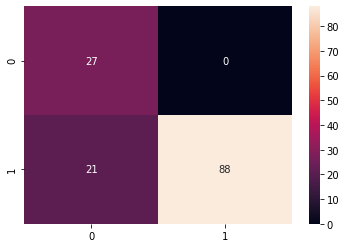

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
a = y_pred_test # predicted
b = y_test.numpy()   #real label
print("\nX-axis is predicted label for test data and Y-axis is true label for test data\n")
classes = np.array(['0','1'])
c = confusion_matrix(a,b)
sns.heatmap(c, annot=True, xticklabels=classes, yticklabels=classes);

In [17]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        27
           1       1.00      0.81      0.89       109

    accuracy                           0.85       136
   macro avg       0.78      0.90      0.81       136
weighted avg       0.91      0.85      0.86       136



# Diabetes

In [37]:
data_diabetes= np.load(r"E:\5002\bi-class\diabetes.npz")
X_train = torch.tensor((data_diabetes['train_X']), dtype=torch.float) 
y_train = torch.tensor((data_diabetes['train_Y']), dtype=torch.long)
X_test = torch.tensor((data_diabetes['test_X']), dtype=torch.float) 
y_test = torch.tensor((data_diabetes['test_Y']), dtype=torch.long)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([615, 8])
torch.Size([615])
torch.Size([153, 8])
torch.Size([153])


In [38]:
from skorch.callbacks import EpochScoring
auc = EpochScoring(scoring='roc_auc', lower_is_better=False) 
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features=8,
    module__num_hidden=10,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    callbacks=[auc]   
)
# fit the model
net.fit(X_train, y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.5820        0.6901       0.6260        0.6860  0.0160
      2     0.6029        0.6868       0.6504        0.6810  0.0170
      3     0.6270        0.6816       0.6504        0.6754  0.0190
      4     0.6505        0.6761       0.6504        0.6702  0.0200
      5     0.6670        0.6711       0.6504        0.6655  0.0180
      6     0.6814        0.6668       0.6585        0.6616  0.0180
      7     0.7002        0.6633       0.6585        0.6584  0.0160
      8     0.7103        0.6604       0.6585        0.6559  0.0180
      9     0.7257        0.6584       0.6585        0.6540  0.0150
     10     0.7344        0.6568       0.6585        0.6525  0.0160


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=8, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [39]:
y_pred_test = net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.6470588235294118
auc score:  0.5


In [63]:
from sklearn.model_selection import GridSearchCV
params = {
    'lr': [0.0001],   
    'max_epochs': [25],
    'module__num_hidden': [i for i in range(1,11)],

}
gs = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.2828        0.6914       0.6263        0.6915  0.0120
      2     0.2828        0.6914       0.6263        0.6915  0.0120
      3     0.2828        0.6913       0.6263        0.6915  0.0110
      4     0.2828        0.6913       0.6263        0.6914  0.0130
      5     0.2828        0.6913       0.6263        0.6914  0.0110
      6     0.2828        0.6913       0.6263        0.6914  0.0130
      7     0.2828        0.6913       0.6263        0.6914  0.0120
      8     0.2828        0.6913       0.6263        0.6914  0.0150
      9     0.2828        0.6913       0.6263        0.6914  0.0130
     10 

GridSearchCV(cv=5, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=8, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid={'lr': [0.0001], 'max_epochs': [25],
                         'module__num_hidden': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=0)

In [64]:
print(gs.best_score_, gs.best_params_)

0.6130081300813008 {'lr': 0.0001, 'max_epochs': 25, 'module__num_hidden': 6}


In [65]:
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features = 8,
    module__num_hidden=6,
    lr=0.001,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    #optimizer__momentum=0.9,
    callbacks=[auc],
    iterator_train__shuffle=True,
)
net.fit(X_train,y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.7566        0.6628       0.6585        0.6586  0.0165
      2     0.7566        0.6628       0.6585        0.6586  0.0170
      3     0.7566        0.6627       0.6585        0.6585  0.0170
      4     0.7566        0.6627       0.6585        0.6585  0.0170
      5     0.7563        0.6627       0.6585        0.6584  0.0180
      6     0.7566        0.6626       0.6585        0.6584  0.0170
      7     0.7566        0.6626       0.6585        0.6583  0.0170
      8     0.7566        0.6625       0.6585        0.6583  0.0180
      9     0.7566        0.6625       0.6585        0.6583  0.0180
     10     0.7569        0.6625       0.6585        0.6582  0.0180


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=8, out_features=6, bias=True)
    (hidden): Linear(in_features=6, out_features=2, bias=True)
  ),
)

In [66]:
y_pred_test=net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.6470588235294118
auc score:  0.5



X-axis is predicted label for test data and Y-axis is true label for test data



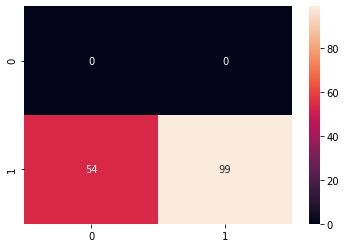

In [67]:
a = y_pred_test # predicted
b = y_test.numpy()   #real label
print("\nX-axis is predicted label for test data and Y-axis is true label for test data\n")
classes = np.array(['0','1'])
c = confusion_matrix(a,b)
sns.heatmap(c, annot=True, xticklabels=classes, yticklabels=classes);

In [68]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.65      0.79       153

    accuracy                           0.65       153
   macro avg       0.50      0.32      0.39       153
weighted avg       1.00      0.65      0.79       153



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Digit

In [69]:
data_digit= np.load(r"E:\5002\bi-class\digit.npz")
X_train = torch.tensor((data_digit['train_X']), dtype=torch.float) 
y_train = torch.tensor((data_digit['train_Y']), dtype=torch.long)
X_test = torch.tensor((data_digit['test_X']), dtype=torch.float) 
y_test = torch.tensor((data_digit['test_Y']), dtype=torch.long)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([800, 64])
torch.Size([800])
torch.Size([200, 64])
torch.Size([200])


In [70]:
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features=64,
    module__num_hidden=10,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    callbacks=[auc]   
)
# fit the model
net.fit(X_train, y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.7004        0.6761       0.6312        0.6430  0.0220
      2     0.7747        0.6017       0.7125        0.5924  0.0190
      3     0.8376        0.5547       0.7750        0.5462  0.0220
      4     0.8615        0.4916       0.7937        0.5169  0.0220
      5     0.8784        0.4536       0.8125        0.5005  0.0240
      6     0.8913        0.4370       0.8375        0.4840  0.0260
      7     0.9005        0.4245       0.8375        0.4746  0.0240
      8     0.9067        0.4177       0.8313        0.4739  0.0260
      9     0.9124        0.4122       0.8375        0.4697  0.0290
     10     0.9141        0.4065       0.8375        0.4692  0.0260


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=64, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [71]:
y_pred_test = net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.9
auc score:  0.9055348321403368


In [72]:
params = {
    'lr': [0.0001],   
    'max_epochs': [25],
    'module__num_hidden': [i for i in range(1,11)],
}
gs = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.5894        0.7230       0.5078        0.7261  0.0150
      2     0.5894        0.7230       0.5078        0.7261  0.0150
      3     0.5939        0.7229       0.5078        0.7260  0.0180
      4     0.5937        0.7228       0.5078        0.7258  0.0160
      5     0.5937        0.7227       0.5078        0.7257  0.0150
      6     0.5937        0.7226       0.5078        0.7256  0.0200
      7     0.5939        0.7225       0.5078        0.7254  0.0180
      8     0.5946        0.7224       0.5078        0.7253  0.0190
      9     0.5922   

GridSearchCV(cv=5, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=64, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid={'lr': [0.0001], 'max_epochs': [25],
                         'module__num_hidden': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=0)

In [73]:
print(gs.best_score_, gs.best_params_)

0.62375 {'lr': 0.0001, 'max_epochs': 25, 'module__num_hidden': 7}


In [74]:
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features = 64,
    module__num_hidden=7,
    lr=0.001,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    #optimizer__momentum=0.9,
    callbacks=[auc],
    iterator_train__shuffle=True,
)
net.fit(X_train,y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.6209        0.7491       0.5375        0.7217  0.0195
      2     0.6248        0.7439       0.5437        0.7145  0.0190
      3     0.6298        0.7384       0.5500        0.7072  0.0260
      4     0.6331        0.7326       0.5500        0.7001  0.0220
      5     0.6376        0.7267       0.5687        0.6932  0.0230
      6     0.6425        0.7212       0.5875        0.6867  0.0220
      7     0.6470        0.7159       0.6062        0.6811  0.0220
      8     0.6500        0.7114       0.6062        0.6765  0.0210
      9     0.6561        0.7077       0.6125        0.6723  0.0220
     10     0.6616        0.7044       0.6125        0.6689  0.0210


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=64, out_features=7, bias=True)
    (hidden): Linear(in_features=7, out_features=2, bias=True)
  ),
)

In [75]:
y_pred_test=net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.505
auc score:  0.5358907147897973



X-axis is predicted label for test data and Y-axis is true label for test data



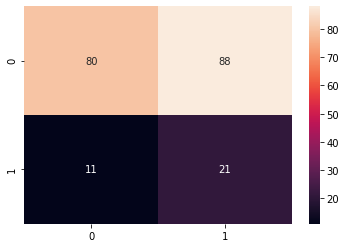

In [76]:
a = y_pred_test # predicted
b = y_test.numpy()   #real label
print("\nX-axis is predicted label for test data and Y-axis is true label for test data\n")
classes = np.array(['0','1'])
c = confusion_matrix(a,b)
sns.heatmap(c, annot=True, xticklabels=classes, yticklabels=classes);

In [77]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       0.88      0.48      0.62       168
           1       0.19      0.66      0.30        32

    accuracy                           0.51       200
   macro avg       0.54      0.57      0.46       200
weighted avg       0.77      0.51      0.57       200



# IRIS

In [78]:
data_iris= np.load(r"E:\5002\bi-class\iris.npz")
X_train = torch.tensor((data_iris['train_X']), dtype=torch.float) 
y_train = torch.tensor((data_iris['train_Y']), dtype=torch.long)
X_test = torch.tensor((data_iris['test_X']), dtype=torch.float) 
y_test = torch.tensor((data_iris['test_Y']), dtype=torch.long)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([120, 4])
torch.Size([120])
torch.Size([30, 4])
torch.Size([30])


In [79]:
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features=4,
    module__num_hidden=10,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    callbacks=[auc]   
)
# fit the model
net.fit(X_train, y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     1.0000        0.6896       0.3333        0.6866  0.0060
      2     1.0000        0.6846       0.8333        0.6770  0.0050
      3     1.0000        0.6754       1.0000        0.6639  0.0040
      4     1.0000        0.6627       1.0000        0.6479  0.0050
      5     1.0000        0.6473       1.0000        0.6301  0.0040
      6     1.0000        0.6301       1.0000        0.6113  0.0040
      7     1.0000        0.6119       1.0000        0.5923  0.0050
      8     1.0000        0.5936       1.0000        0.5737  0.0050
      9     1.0000        0.5757       1.0000        0.5560  0.0050
     10     1.0000        0.5586       1.0000        0.5397  0.0040


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=4, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [80]:
y_pred_test = net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.9666666666666667
auc score:  0.9500000000000001


In [81]:
params = {
    'lr': [0.0001],   
    'max_epochs': [25],
    'module__num_hidden': [i for i in range(1,11)],
}
gs = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     1.0000        0.5809       1.0000        0.5788  0.0030
      2     1.0000        0.5809       1.0000        0.5787  0.0030
      3     1.0000        0.5809       1.0000        0.5787  0.0030
      4     1.0000        0.5808       1.0000        0.5787  0.0030
      5     1.0000        0.5808       1.0000        0.5786  0.0030
      6     1.0000        0.5808       1.0000        0.5785  0.0030
      7     1.0000        0.5807       1.0000        0.5785  0.0040
      8     1.0000        0.5806       1.0000        0.5784  0.0030
      9     1.0000   

GridSearchCV(cv=5, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=4, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid={'lr': [0.0001], 'max_epochs': [25],
                         'module__num_hidden': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=0)

In [82]:
print(gs.best_score_, gs.best_params_)

0.7916666666666667 {'lr': 0.0001, 'max_epochs': 25, 'module__num_hidden': 10}


In [83]:
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features = 4,
    module__num_hidden=10,
    lr=0.001,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    #optimizer__momentum=0.9,
    callbacks=[auc],
    iterator_train__shuffle=True,
)
net.fit(X_train,y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     1.0000        0.6035       0.6667        0.6025  0.0050
      2     1.0000        0.6035       0.6667        0.6025  0.0040
      3     1.0000        0.6034       0.6667        0.6024  0.0040
      4     1.0000        0.6034       0.6667        0.6024  0.0040
      5     1.0000        0.6033       0.6667        0.6023  0.0040
      6     1.0000        0.6033       0.6667        0.6023  0.0040
      7     1.0000        0.6032       0.6667        0.6022  0.0050
      8     1.0000        0.6032       0.6667        0.6022  0.0050
      9     1.0000        0.6031       0.6667        0.6021  0.0050
     10     1.0000        0.6031       0.6667        0.6021  0.0040


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=4, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [84]:
y_pred_test=net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.6666666666666666
auc score:  0.5



X-axis is predicted label for test data and Y-axis is true label for test data



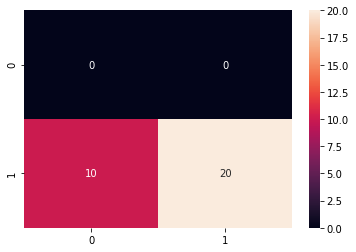

In [85]:
a = y_pred_test # predicted
b = y_test.numpy()   #real label
print("\nX-axis is predicted label for test data and Y-axis is true label for test data\n")
classes = np.array(['0','1'])
c = confusion_matrix(a,b)
sns.heatmap(c, annot=True, xticklabels=classes, yticklabels=classes);

In [87]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80        30

    accuracy                           0.67        30
   macro avg       0.50      0.33      0.40        30
weighted avg       1.00      0.67      0.80        30



# Wine

In [88]:
data_wine= np.load(r"E:\5002\bi-class\wine.npz")
X_train = torch.tensor((data_wine['train_X']), dtype=torch.float) 
y_train = torch.tensor((data_wine['train_Y']), dtype=torch.long)
X_test = torch.tensor((data_wine['test_X']), dtype=torch.float) 
y_test = torch.tensor((data_wine['test_Y']), dtype=torch.long)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([142, 13])
torch.Size([142])
torch.Size([36, 13])
torch.Size([36])


In [89]:
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features=13,
    module__num_hidden=10,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    callbacks=[auc]   
)
# fit the model
net.fit(X_train, y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.5000        0.9150       0.4138        0.8995  0.0045
      2     0.5000        0.9150       0.4138        0.8995  0.0040
      3     0.5000        0.9150       0.4138        0.8995  0.0040
      4     0.5000        0.9150       0.4138        0.8995  0.0050
      5     0.5000        0.9150       0.4138        0.8995  0.0050
      6     0.5000        0.9150       0.4138        0.8995  0.0050
      7     0.5000        0.9150       0.4138        0.8995  0.0070
      8     0.5000        0.9150       0.4138        0.8995  0.0060
      9     0.5000        0.9150       0.4138        0.8995  0.0050
     10     0.5000        0.9150       0.4138        0.8995  0.0050


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=13, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [90]:
y_pred_test = net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.3888888888888889
auc score:  0.5


In [91]:
params = {
    'lr': [0.0001],   
    'max_epochs': [25],
    'module__num_hidden': [i for i in range(1,11)],
}
gs = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_features, num_hidden.
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.5000        0.9133       0.3913        0.9220  0.0030
      2     0.5000        0.9133       0.3913        0.9220  0.0040
      3     0.5000        0.9133       0.3913        0.9220  0.0040
      4     0.5000        0.9133       0.3913        0.9220  0.0040
      5     0.5000        0.9133       0.3913        0.9220  0.0040
      6     0.5000        0.9133       0.3913        0.9220  0.0040
      7     0.5000        0.9133       0.3913        0.9220  0.0050
      8     0.5000        0.9133       0.3913        0.9220  0.0040
      9     0.5000   

GridSearchCV(cv=5, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=13, out_features=10, bias=True)
    (hidden): Linear(in_features=10, out_features=2, bias=True)
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid={'lr': [0.0001], 'max_epochs': [25],
                         'module__num_hidden': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=0)

In [94]:
print(gs.best_score_, gs.best_params_)

0.6041871921182266 {'lr': 0.0001, 'max_epochs': 25, 'module__num_hidden': 9}


In [95]:
net = NeuralNetClassifier(
    module=MyModule,
    module__num_features = 13,
    module__num_hidden=9,
    lr=0.0001,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    #optimizer__momentum=0.9,
    callbacks=[auc],
    iterator_train__shuffle=True,
)
net.fit(X_train,y_train)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.9265        0.7115       0.5862        0.7271  0.0050
      2     0.9265        0.7115       0.5862        0.7271  0.0040
      3     0.9265        0.7115       0.5862        0.7271  0.0050
      4     0.9265        0.7115       0.5862        0.7271  0.0040
      5     0.9265        0.7115       0.5862        0.7271  0.0050
      6     0.9265        0.7115       0.5862        0.7271  0.0040
      7     0.9265        0.7115       0.5862        0.7271  0.0050
      8     0.9265        0.7115       0.5862        0.7271  0.0060
      9     0.9265        0.7115       0.5862        0.7271  0.0050
     10     0.9265        0.7115       0.5862        0.7271  0.0060


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (input): Linear(in_features=13, out_features=9, bias=True)
    (hidden): Linear(in_features=9, out_features=2, bias=True)
  ),
)

In [96]:
y_pred_test=net.predict(X_test)
print("accuract score: ", accuracy_score(y_test, y_pred_test))
print("auc score: ", roc_auc_score(y_test, y_pred_test))

accuract score:  0.6111111111111112
auc score:  0.5



X-axis is predicted label for test data and Y-axis is true label for test data



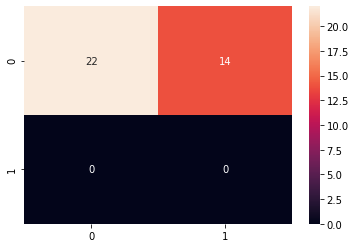

In [97]:
a = y_pred_test # predicted
b = y_test.numpy()   #real label
print("\nX-axis is predicted label for test data and Y-axis is true label for test data\n")
classes = np.array(['0','1'])
c = confusion_matrix(a,b)
sns.heatmap(c, annot=True, xticklabels=classes, yticklabels=classes);

In [98]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       1.00      0.61      0.76        36
           1       0.00      0.00      0.00         0

    accuracy                           0.61        36
   macro avg       0.50      0.31      0.38        36
weighted avg       1.00      0.61      0.76        36



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
